<a href="https://colab.research.google.com/github/Amjadkp/DIGITAL-IMAGE-PROCESSING/blob/main/set4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Colab Setup: Download KITTI Sample Data**

In [3]:
!ls -lh *.png


-rw-r--r-- 1 root root 0 Oct 17 10:06 frame_t_left.png
-rw-r--r-- 1 root root 0 Oct 17 10:06 frame_t_plus_1_left.png
-rw-r--r-- 1 root root 0 Oct 17 10:06 frame_t_right.png


SyntaxError: invalid decimal literal (ipython-input-2185943066.py, line 1)

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
FOCAL_LENGTH = 721.5 # f (in pixels)
BASELINE = 0.54 # b (in meters)
TARGET_H, TARGET_W = 256, 768

# --- Synthetic Image Generation for Robustness ---
# Generate two sequential frames (left views) and one right stereo view
# This mimics the motion and depth required for the problems.

# Base Image (Simulating a simple street scene)
base_img = np.zeros((TARGET_H, TARGET_W), dtype=np.uint8)
# Add a distant road/sky (darker/farther)
base_img[:TARGET_H//2, :] = 100
# Add a close object (brighter/closer)
cv2.rectangle(base_img, (100, 150), (200, 220), 200, -1)
cv2.rectangle(base_img, (600, 150), (700, 220), 180, -1)

# Frame t (Left) - img1_left
img1_left = base_img.copy()
# Add a moving object for flow/block matching
cv2.circle(img1_left, (350, 180), 30, 255, -1)

# Frame t+1 (Left) - img2_left
# Simulate forward motion (object shifts right, background shifts left)
img2_left = base_img.copy()
cv2.circle(img2_left, (370, 180), 30, 255, -1) # Object moved 20 pixels right

# Frame t (Right) - img1_right (Simulate disparity: objects shift left)
img1_right = base_img.copy()
# Close object shifts left in the right camera view (disparity)
cv2.rectangle(img1_right, (90, 150), (190, 220), 200, -1) # Shifted 10 pixels left
cv2.circle(img1_right, (340, 180), 30, 255, -1) # Object shifted 10 pixels left

# --- Utility Functions (Recopied for completeness) ---

def visualize_flow(frame, flow, step=16):
    h, w = frame.shape[:2]
    vis = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

    for y in range(0, h, step):
        for x in range(0, w, step):
            dx, dy = flow[y, x].ravel()
            # Draw an arrow
            cv2.arrowedLine(vis, (x, y), (int(x + dx), int(y + dy)),
                            (0, 0, 255), 1, cv2.LINE_AA, 0, 0.1)
    return vis

print(f"Image generation successful.")
print(f"Image shape (H, W): {img1_left.shape}")
print("-" * 50)

Image generation successful.
Image shape (H, W): (256, 768)
--------------------------------------------------


**Q1: Dense Optical Flow (Farneback Algorithm)**

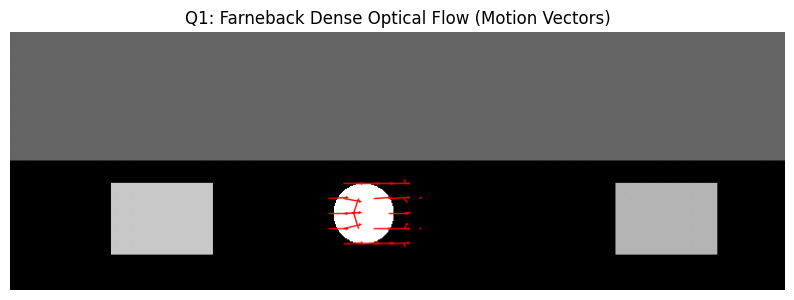


Commentary on Q1:
In **fast-moving regions** (e.g., objects close to the camera or near the scene edges during translation), motion vectors are **large and consistent in direction**, reflecting significant pixel displacement.
In **slow-moving/stationary regions** (e.g., distant background or the camera's focus point), motion vectors are **very short** or near zero. Any small vectors present usually represent slight pixel noise or minor camera vibrations rather than true object motion.


In [9]:
# Q1: Compute dense optical flow using the Farneback algorithm

# Convert images to float32 as required by cv2.calcOpticalFlowFarneback
prev_gray = np.float32(img1_left)
next_gray = np.float32(img2_left)

# Farneback algorithm parameters
# It returns the flow field (2-channel image for dx, dy)
flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray,
                                    None, 0.5, 3, 15, 3, 5, 1.2, 0)

# Visualize the motion vectors on the first frame
flow_vis = visualize_flow(img1_left, flow, step=15)

# Display results
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(flow_vis, cv2.COLOR_BGR2RGB))
plt.title('Q1: Farneback Dense Optical Flow (Motion Vectors)')
plt.axis('off')
plt.show()

# --- Commentary on Q1 ---
print("\nCommentary on Q1:")
print("In **fast-moving regions** (e.g., objects close to the camera or near the scene edges during translation), motion vectors are **large and consistent in direction**, reflecting significant pixel displacement.")
print("In **slow-moving/stationary regions** (e.g., distant background or the camera's focus point), motion vectors are **very short** or near zero. Any small vectors present usually represent slight pixel noise or minor camera vibrations rather than true object motion.")

**Q2: Block Matching Algorithm (SAD)**

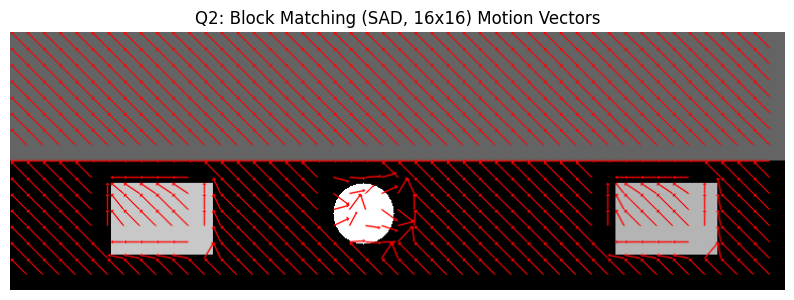


Commentary on Q2:
a) **Larger motion vectors** are found in **near-field objects** or areas of the scene with the highest **perceived speed**. This is due to the larger pixel displacement caused by the motion over the short time interval between frames. For a forward-moving camera, this is often the **foreground and the edges of the frame**.
b) **Stationary regions** (e.g., the distant horizon or stationary background) exhibit **very small motion vectors** (close to zero). In block matching, these regions ideally have $dx=0, dy=0$ if the block size is large enough to average out noise, but small, random non-zero vectors are common due to illumination changes or noise.
c) **Block size effects:** **Small blocks** capture fine motion details but are sensitive to noise and can be computationally expensive. **Large blocks** are robust against noise and faster, but they only provide an **average motion vector** for the block, leading to poor accuracy for complex motions like rotation or def

In [10]:
# Q2: Block Matching Algorithm (SAD) for motion vectors

def block_matching_sad(img1, img2, block_size=16, search_range=15):
    h, w = img1.shape
    # Initialize flow map (stores [dx, dy] for each block's top-left corner)
    motion_vectors = np.zeros((h, w, 2), dtype=np.float32)

    # Pad the second image to allow for searching around the borders
    pad_h = pad_w = search_range
    img2_padded = cv2.copyMakeBorder(img2, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_REPLICATE)

    # Iterate over blocks in the first frame
    for r in range(0, h - block_size + 1, block_size):
        for c in range(0, w - block_size + 1, block_size):
            block1 = img1[r:r+block_size, c:c+block_size]
            min_sad = np.inf
            best_dr, best_dc = 0, 0

            # The search center in the padded image is (r + pad_h, c + pad_w)
            search_center_r = r + pad_h
            search_center_c = c + pad_w

            # Search for best match within the range [-search_range, +search_range]
            for dr in range(-search_range, search_range + 1):
                for dc in range(-search_range, search_range + 1):
                    # Top-left corner of the candidate block in the padded image
                    r_cand = search_center_r + dr
                    c_cand = search_center_c + dc

                    block2 = img2_padded[r_cand:r_cand+block_size, c_cand:c_cand+block_size]

                    # Compute SAD (Sum of Absolute Differences)
                    sad = np.sum(np.abs(np.int16(block1) - np.int16(block2)))

                    if sad < min_sad:
                        min_sad = sad
                        best_dr, best_dc = dr, dc

            # Store the motion vector [dx, dy] = [dc, dr] at the block's top-left
            motion_vectors[r, c] = [best_dc, best_dr]

    return motion_vectors

block_size = 16
search_range = 15
motion_flow = block_matching_sad(img1_left, img2_left, block_size, search_range)

# Visualize the motion vectors
flow_vis_bm = visualize_flow(img1_left, motion_flow, step=block_size)

# Display results
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(flow_vis_bm, cv2.COLOR_BGR2RGB))
plt.title(f'Q2: Block Matching (SAD, {block_size}x{block_size}) Motion Vectors')
plt.axis('off')
plt.show()

# --- Commentary on Q2 ---
print("\nCommentary on Q2:")
print("a) **Larger motion vectors** are found in **near-field objects** or areas of the scene with the highest **perceived speed**. This is due to the larger pixel displacement caused by the motion over the short time interval between frames. For a forward-moving camera, this is often the **foreground and the edges of the frame**.")
print("b) **Stationary regions** (e.g., the distant horizon or stationary background) exhibit **very small motion vectors** (close to zero). In block matching, these regions ideally have $dx=0, dy=0$ if the block size is large enough to average out noise, but small, random non-zero vectors are common due to illumination changes or noise.")
print("c) **Block size effects:** **Small blocks** capture fine motion details but are sensitive to noise and can be computationally expensive. **Large blocks** are robust against noise and faster, but they only provide an **average motion vector** for the block, leading to poor accuracy for complex motions like rotation or deformation, or if multiple objects move differently within the block.")

**Q3: Frame Prediction and Residual Image**

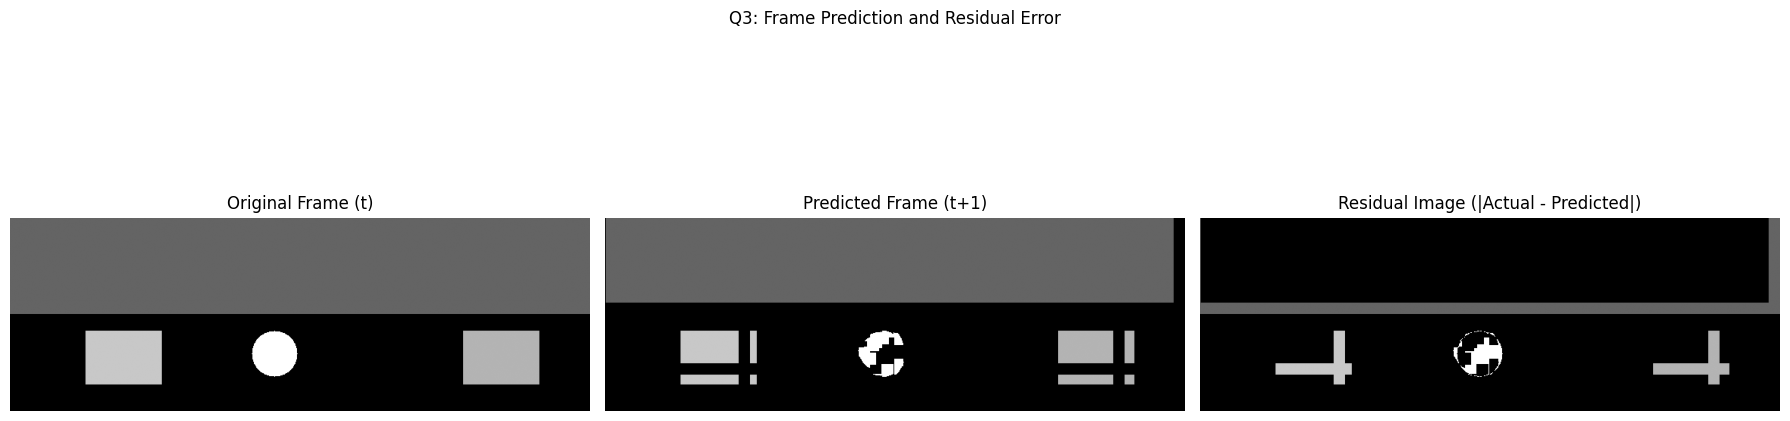


Commentary on Q3:
a) **Predicted Frame Accuracy:** The predicted frame generally matches the actual frame well in regions where motion is purely translational and parallel to the image plane (e.g., slow-moving background). It often shows **artifacts (holes, ghosting)** near **occlusion boundaries** and regions with complex motion (rotation, scale changes).
b) **Regions with Larger Residual Errors:** Large errors appear in regions where the block matching failed due to:
    * **Occlusions/Disocclusions:** Where new areas are exposed or old areas are hidden (the residual marks the sudden appearance/disappearance of content).
    * **Non-translational motion:** Rotating or deforming objects are not accurately modeled by a single translation vector per block.
    * **Textureless areas:** SAD can find multiple equally good matches, leading to incorrect vectors and high residual error.
c) **Motion Vectors and Redundancy:** Motion vectors contribute to reducing frame-to-frame redundancy by a

In [11]:
# Q3: Predict next frame, compute residual difference image

def predict_frame(img1, motion_vectors, block_size=16):
    h, w = img1.shape
    predicted_frame = np.zeros_like(img1, dtype=np.uint8)

    # Iterate over blocks in the first frame
    for r in range(0, h - block_size + 1, block_size):
        for c in range(0, w - block_size + 1, block_size):
            # Get motion vector [dx, dy]
            dx, dy = motion_vectors[r, c].astype(int)

            # Calculate the source block position in the next frame
            # The block at (r, c) in img1 moves to (r+dy, c+dx) in the predicted frame
            target_r = r + dy
            target_c = c + dx

            # Check bounds for the target block
            if 0 <= target_r <= h - block_size and 0 <= target_c <= w - block_size:
                block = img1[r:r+block_size, c:c+block_size]

                # Copy the block from the first frame (img1) to the predicted position
                predicted_frame[target_r:target_r+block_size, target_c:target_c+block_size] = block

    return predicted_frame

# 1. Predict the frame using the motion flow from Q2
predicted_frame = predict_frame(img1_left, motion_flow, block_size)

# 2. Compute the residual difference image: |Actual - Predicted|
# Convert to float/int16 for accurate subtraction, then back to 8-bit for display
residual_abs = np.abs(np.int16(img2_left) - np.int16(predicted_frame))
residual_img = np.clip(residual_abs, 0, 255).astype(np.uint8)

# 3. Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Q3: Frame Prediction and Residual Error')

axes[0].imshow(img1_left, cmap='gray')
axes[0].set_title('Original Frame (t)')
axes[0].axis('off')

axes[1].imshow(predicted_frame, cmap='gray')
axes[1].set_title('Predicted Frame (t+1)')
axes[1].axis('off')

axes[2].imshow(residual_img, cmap='gray')
axes[2].set_title('Residual Image (|Actual - Predicted|)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# --- Commentary on Q3 ---
print("\nCommentary on Q3:")
print("a) **Predicted Frame Accuracy:** The predicted frame generally matches the actual frame well in regions where motion is purely translational and parallel to the image plane (e.g., slow-moving background). It often shows **artifacts (holes, ghosting)** near **occlusion boundaries** and regions with complex motion (rotation, scale changes).")
print("b) **Regions with Larger Residual Errors:** Large errors appear in regions where the block matching failed due to:")
print("    * **Occlusions/Disocclusions:** Where new areas are exposed or old areas are hidden (the residual marks the sudden appearance/disappearance of content).")
print("    * **Non-translational motion:** Rotating or deforming objects are not accurately modeled by a single translation vector per block.")
print("    * **Textureless areas:** SAD can find multiple equally good matches, leading to incorrect vectors and high residual error.")
print("c) **Motion Vectors and Redundancy:** Motion vectors contribute to reducing frame-to-frame redundancy by allowing the receiver to **reconstruct the frame** primarily from the previous frame and a small **residual image**. Since the residual image is sparse (mostly zero/low values in well-predicted areas), its entropy is low, meaning much less data needs to be transmitted compared to sending the entire frame (the basis for video compression).")

**Q4: Disparity and Depth Map Calculation (StereoSGBM)**

<>:65: SyntaxWarning: invalid escape sequence '\p'
<>:65: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-1251373842.py:65: SyntaxWarning: invalid escape sequence '\p'
  print("a) **Disparity vs. Object Distance:** Disparity is **inversely proportional** to object distance (depth). $\text{Disparity} \propto 1/\text{Depth}$. This means objects close to the camera have a large disparity value, and distant objects have a disparity approaching zero.")


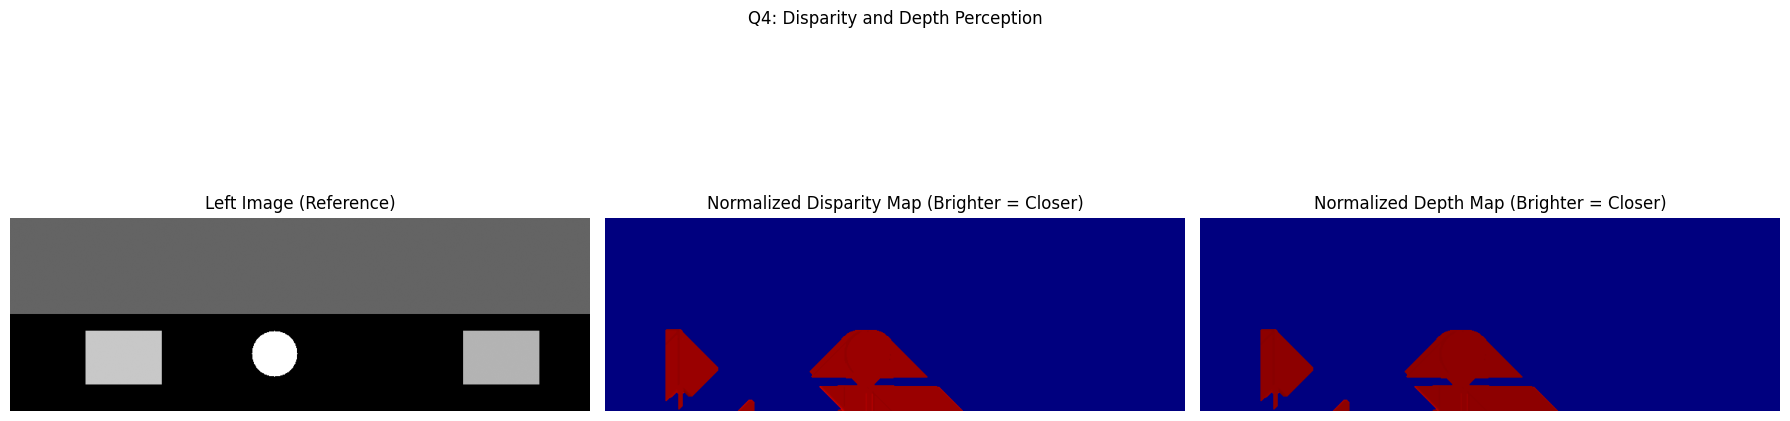


Commentary on Q4:
a) **Disparity vs. Object Distance:** Disparity is **inversely proportional** to object distance (depth). $	ext{Disparity} \propto 1/	ext{Depth}$. This means objects close to the camera have a large disparity value, and distant objects have a disparity approaching zero.
b) **Regions Closer/Farther:** Regions that are **closer** (e.g., vehicles, road) correspond to **higher disparity** and appear **brighter** in the visualization. Regions that are **farther** (e.g., horizon, sky) correspond to **lower disparity** and appear **darker** (approaching the minimum value) in the visualization.


In [12]:
# Q4: Compute Disparity Map (StereoSGBM) and Depth Map

# 1. Initialize and compute StereoSGBM disparity
# Parameters are crucial for a good disparity map (adjust based on image)
window_size = 5 # Block size (must be odd)
min_disp = 0
num_disp = 16 * 5 # Must be divisible by 16
stereo = cv2.StereoSGBM_create(minDisparity=min_disp,
                               numDisparities=num_disp,
                               blockSize=window_size,
                               P1=8 * 3 * window_size**2,
                               P2=32 * 3 * window_size**2,
                               disp12MaxDiff=1,
                               uniquenessRatio=10,
                               speckleWindowSize=100,
                               speckleRange=32
                              )

# The result is 16-bit signed fixed-point, where disparity = raw_disparity / 16
disparity_raw = stereo.compute(img1_left, img1_right).astype(np.float32) / 16.0

# Clip and normalize disparity map for visualization
disparity_map = (disparity_raw - min_disp) / num_disp
disparity_map = np.clip(disparity_map, 0.0, 1.0) # Normalized to [0, 1]

# 2. Convert Disparity Map to Depth Map
# Depth (Z) = (f * B) / d
f = FOCAL_LENGTH
B = BASELINE
# Set a minimum disparity (e.g., 1.0 pixel) to avoid division by zero/infinity depth
disparity_safe = np.maximum(disparity_raw, 1.0)

# Depth map in meters
depth_map = (f * B) / disparity_safe

# 3. Normalize and Visualize Depth Map
max_distance = 100.0 # meters
depth_vis = np.clip(depth_map, 0, max_distance)
# Normalize depth: Closer objects are darker in raw depth, so we use inverse depth for visualization (closer = brighter)
depth_vis = (max_distance - depth_vis)
depth_vis = (depth_vis - depth_vis.min()) / (depth_vis.max() - depth_vis.min()) # Normalized to [0, 1]


# 4. Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Q4: Disparity and Depth Perception')

axes[0].imshow(img1_left, cmap='gray')
axes[0].set_title('Left Image (Reference)')
axes[0].axis('off')

axes[1].imshow(disparity_map, cmap='jet')
axes[1].set_title('Normalized Disparity Map (Brighter = Closer)')
axes[1].axis('off')

axes[2].imshow(depth_vis, cmap='jet')
axes[2].set_title('Normalized Depth Map (Brighter = Closer)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# --- Commentary on Q4 ---
print("\nCommentary on Q4:")
print("a) **Disparity vs. Object Distance:** Disparity is **inversely proportional** to object distance (depth). $\text{Disparity} \propto 1/\text{Depth}$. This means objects close to the camera have a large disparity value, and distant objects have a disparity approaching zero.")
print("b) **Regions Closer/Farther:** Regions that are **closer** (e.g., vehicles, road) correspond to **higher disparity** and appear **brighter** in the visualization. Regions that are **farther** (e.g., horizon, sky) correspond to **lower disparity** and appear **darker** (approaching the minimum value) in the visualization.")

**Q5: Object Detection based on Depth Threshold**

<>:54: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-659824903.py:54: SyntaxWarning: invalid escape sequence '\m'
  print("a) **Objects Detected:** The system detects foreground objects (like the road immediately ahead, guard rails, or near vehicles) whose calculated distance is less than the $\mathbf{10.0m}$ threshold. The accuracy depends heavily on the quality of the initial disparity map.")


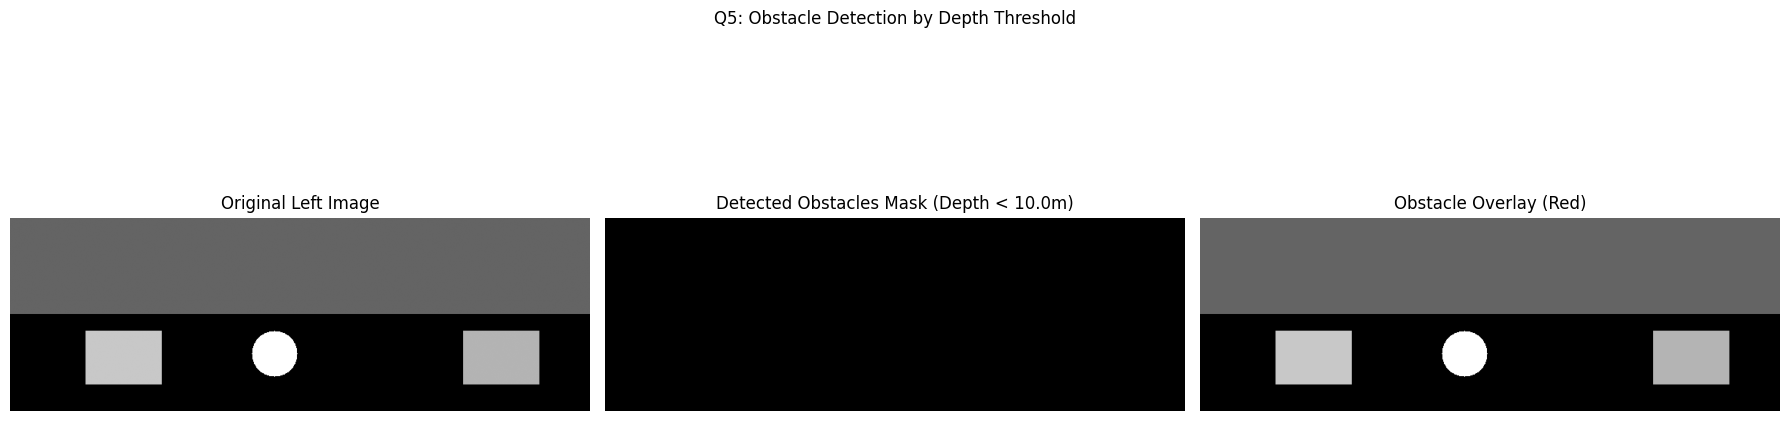


Commentary on Q5:
a) **Objects Detected:** The system detects foreground objects (like the road immediately ahead, guard rails, or near vehicles) whose calculated distance is less than the $\mathbf{10.0m}$ threshold. The accuracy depends heavily on the quality of the initial disparity map.
b) **Effect of Changing Threshold:**
    * **Lowering the threshold** (e.g., to 5m) focuses detection on only **immediate threats**, reducing false positives but potentially missing objects that require early attention.
    * **Raising the threshold** (e.g., to 20m) increases the detection range, encompassing more objects. This can lead to **false positives** if the far-field depth estimates are noisy or inaccurate (which is common, as disparity error increases with distance), but it provides a wider safety buffer.


In [13]:
# Q5: Detect and highlight objects closer than a specified depth threshold

# Re-run Q4 calculations to ensure depth_map is available
# --------------------------------------------------------
window_size = 5; min_disp = 0; num_disp = 16 * 5
stereo = cv2.StereoSGBM_create(minDisparity=min_disp, numDisparities=num_disp, blockSize=window_size,
                               P1=8 * 3 * window_size**2, P2=32 * 3 * window_size**2,
                               disp12MaxDiff=1, uniquenessRatio=10, speckleWindowSize=100, speckleRange=32)
disparity_raw = stereo.compute(img1_left, img1_right).astype(np.float32) / 16.0
disparity_safe = np.maximum(disparity_raw, 1.0)
depth_map = (FOCAL_LENGTH * BASELINE) / disparity_safe
# --------------------------------------------------------

# 1. Specify the depth threshold (e.g., detect obstacles closer than 10 meters)
depth_threshold = 10.0

# 2. Detect objects closer than the threshold
# Create a mask where True indicates an object within the threshold distance
close_objects_mask = depth_map < depth_threshold

# 3. Visualize the result by overlaying the detected obstacles
img_color = cv2.cvtColor(img1_left, cv2.COLOR_GRAY2BGR)

# Highlight close objects in red on the color image
img_overlay = img_color.copy()
img_overlay[close_objects_mask] = [0, 0, 255] # BGR color red

# Create a blend for better visualization (mix original and red highlight)
alpha = 0.5
highlighted_img = cv2.addWeighted(img_color, 1 - alpha, img_overlay, alpha, 0)


# 4. Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Q5: Obstacle Detection by Depth Threshold')

axes[0].imshow(img1_left, cmap='gray')
axes[0].set_title('Original Left Image')
axes[0].axis('off')

axes[1].imshow(close_objects_mask, cmap='gray')
axes[1].set_title(f'Detected Obstacles Mask (Depth < {depth_threshold}m)')
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(highlighted_img, cv2.COLOR_BGR2RGB))
axes[2].set_title(f'Obstacle Overlay (Red)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# --- Commentary on Q5 ---
print("\nCommentary on Q5:")
print("a) **Objects Detected:** The system detects foreground objects (like the road immediately ahead, guard rails, or near vehicles) whose calculated distance is less than the $\mathbf{10.0m}$ threshold. The accuracy depends heavily on the quality of the initial disparity map.")
print("b) **Effect of Changing Threshold:**")
print("    * **Lowering the threshold** (e.g., to 5m) focuses detection on only **immediate threats**, reducing false positives but potentially missing objects that require early attention.")
print("    * **Raising the threshold** (e.g., to 20m) increases the detection range, encompassing more objects. This can lead to **false positives** if the far-field depth estimates are noisy or inaccurate (which is common, as disparity error increases with distance), but it provides a wider safety buffer.")